In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Introduction

Machine learning literature makes heavy use of probabilistic graphical models
and bayesian statistics. In fact, state of the art (SOTA) architectures, such as
[variational autoencoders][vae-blog] (VAE) or [generative adversarial
networks][gan-blog] (GAN), are intrinsically stochastic by nature. To
wholesomely understand research in this field not only do we need a broad
knowledge of mathematics, probability, and optimization but we somehow need
intuition about how these concepts are applied to real world problems. For
example, one of the most common applications of deep learning techniques is
vision. We may want to classify images or generate new ones. Most SOTA
techniques pose these problems in a probabilistic framework. We frequently see
things like $p(\mathbf{x}|\mathbf{z})$ where $\mathbf{x}$ is an image and
$\mathbf{z}$ is a latent variable. What do we mean by the probability of an
image? What is a latent variable, and why is it necessary[^Bishop2006] to pose
the problems this way?
                                                                                                                                                                                                                    
Short answer, it is necessary due to the inherent uncertainty of our universe.
In this case, uncertainty in image acquisition can be introduced via many
sources, such as the recording apparatus, the finite precision of our
measurements, as well as the intrinsic stochasticity of the process being
measured. Perhaps the most important source of uncertainty we will consider is
due to there being sources of variability that are themselves unobserved.
Probability theory provides us with a framework to reason in the presence of
uncertainty and information theory allows us to quantify uncertainty. As we 
elluded earlier the field of machine learning makes heavy use of both, and
this is no coincidence.


## Representations

How do we describe a face? The word "face" is a symbol and this symbol means
different things to different people. Yet, there is enough commonality between
our interpretations that we are able to effectively communicate with one
another using the word. How is that? What are the underlying features of faces
that we all hold common? Why is a simple smiley face clip art so obviously
perceived as a face? To make it more concrete, why are two simple ellipses
decorated underneath by a short curve so clearly a face, while an eye lid,
lower lip, one ear and a nostril, not? 


**Insert Image of Faces**
*Left: Most would likely agree, this is clearly a face. Middle:
With nearly all of the details removed, a mere two circles and
curve are enough to create what the author still recognizes
as a face. Right: Does this look like a face to you? An ear, 
nostril, eyelid, and lip do not seem to convey a face as clearly
as the eyes and the mouth do. We will quantify this demonstration
shortly.*

Features, or representations, are built on the idea that characteristics of the
symbol "face" are not a property of any one face. Rather, they only arise from
the myriad of things we use the symbol to represent. In other words, a
particular face is not ascribed meaning by the word "face" - the word "face"
derives meaning from the many faces it represents. This suggests that facial
characteristics can be described through the statistical properties of all
faces. Loosely speaking, these underlying statistical characteristics are what
the machine learning field often calls latent variables.


## Probability of an Image

Most images are contaminated with noise that must be addressed. At the
highest level, we have noise being added to the data by the imaging device. The
next level of uncertainty comes as a consequence of discretization.
Images in reality are continuous but in the process of imaging we only measure
certain points along the face. Consider for example a military satellite
tracking a vehicle. If one wishes to predict the future location of the van,
the prediction is limited to be within one of the discrete cells that make up
its measurements. However, the true location of the van could be anywhere
within that grid cell. There is also intrinsic stochasticity at the atomic
level that we ignore. The fluctuations taking place at that scale are assumed
to be averaged out in our observations.

The unobserved sources of variability will be our primary focus. Before we
address that, let us lay down some preliminary concepts. We are going to assume
that there exists some true unknown process that determines what faces look
like. A dataset of faces can then be considered as a sample of this process at 
various points throughout its life. This suggests that these snapshots are a
outputs of the underlying data generating process. Considering the many
sources of uncertainty outlined above, it is natural to describe this process
as a probability distribution. There will be many ways to interpret the data as
a probability, but we will begin by considering any one image to be the result
of a data generating distribution, $P_{data}(\mathbf{x})$. Here $\mathbf{x}$ is considered to be
an image of a face with $n$ pixels. So $P_{data}$ is a joint distribution over
each pixel of the frame with a probability density function (pdf),
$p_{data}(x_1,x_2,\dots,x_n)$.

To build intuition about what $p_{data}(\mathbf{x})$ is and how it relates to
the assumed data generating process, we will explore a simple example. Take an
image with only 2 pixels... [$x_1$,$x_2$] where both $x_1$ and $x_2$ are in
[0,1]. Each image can be considered as a two dimensional point, in
$\mathbb{R}^2$. All possible images would occupy a square in the 2 dimensional
plane. An example of what this might look like can be seen in Figure
\ref{fig:images_in_2dspace} on page \pageref{fig:images_in_2dspace}. Any one
point inside the unit square would represent an image. For example the image
associated with the point $(0.25,0.85)$ is shown below.

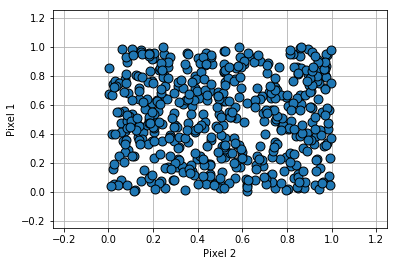

In [2]:
x1 = np.random.uniform(size=500)
x2 = np.random.uniform(size=500)
fig = plt.figure();
ax = fig.add_subplot(1,1,1);
ax.scatter(x1,x2, edgecolor='black', s=80);
ax.grid();
ax.set_axisbelow(True);
ax.set_xlim(-0.25,1.25); ax.set_ylim(-0.25,1.25)
ax.set_xlabel('Pixel 2'); ax.set_ylabel('Pixel 1'); plt.savefig('images_in_2dspace.pdf')

Any one point inside the unit square would represent an image. For example the image associated with the point $(0.25,0.85)$ is shown below.

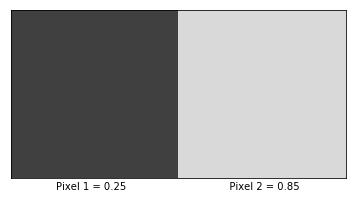

In [3]:
im = [(0.25, 0.85)]
plt.imshow(im, cmap='gray',vmin=0,vmax=1)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    left='off',
    right='off'
)
plt.xticks([])
plt.yticks([])
plt.xlabel('Pixel 1 = 0.25                                 Pixel 2 = 0.85')
plt.savefig('sample_2dspace_image.pdf')

Now consider the case where there is some 
process correlating the two variables. This 
would be similar to their being some rules behind
the structure of faces. We know, that this must be
the case because if it weren't then faces would
be created randomly and we would not see the 
patterns that was do. In 
this case, the pixels would be correlated in 
some manner due to the mechanism driving the
construction of faces. In this simple case, 
let's consider a direct correlation of the 
form $x_1 = \frac{1}{2} \cos(2\pi x_2)+\frac{1}{2}+\epsilon$ 
where $\epsilon$ is a noise term coming from
a low variability normal distribution 
$\epsilon \sim N(0,\frac{1}{10})$. We see 
in Figure \ref{fig:structured_images_in_2dspace}
on page \pageref{fig:structured_images_in_2dspace}
that in this case, the images plotted
in two dimensions resulting from this 
relationship form a distinct pattern.

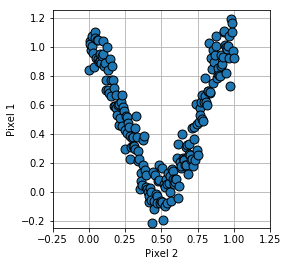

In [4]:
x1 = lambda x2: 0.5*np.cos(2*np.pi*x2)+0.5
x2 = np.linspace(0,1,200)
eps = np.random.normal(scale=0.1, size=200)
fig = plt.figure();
ax = fig.add_subplot(1,1,1);
ax.scatter(x2,x1(x2)+eps, edgecolor='black', s=80);
ax.grid();
ax.set_axisbelow(True);
ax.set_xlim(-0.25,1.25); ax.set_ylim(-0.25,1.25); plt.axes().set_aspect('equal')
ax.set_xlabel('Pixel 2'); ax.set_ylabel('Pixel 1'); plt.savefig('structured_images_in_2dspace.pdf')

We will refer to the structure suggested by 
the two dimensional points as the 'manifold'.
This is a common practice when analyzing images.
A 28 by 28 dimensional image will be a point in
784 dimensional space. If we are examining 
images with structure, various images of the
number 2 for example, then it turns out that 
these images will form a manifold in 784 
dimensional space. In most cases, as is the 
case in our contrived example, this manifold 
exists in a lower dimensional space than that
of the images themselves. The goal is to 'learn'
this manifold. In our simple case we can describe
the manifold as a function of only 1 variable 
$$f(t) = <t,\frac{1}{2} \cos(2\pi t)+\frac{1}{2}>$$ 
This is what we would call the underlying data 
generating process. In practice we usually 
describe the manifold in terms of a probability
distribution. We will refer to the data 
generating distribution in our example as 
$p_{test}(x_1, x_2)$. Why did we choose a 
probability to describe the manifold created 
by the data generating process? How might this
probability be interpreted?

Learning the actual distribution turns out to 
be a difficult task. Here we will use a
common non parametric technique for describing
distributions, the histogram. Looking at a 
histogram of the images, or two dimensional points,
will give us insight into the structure of the 
distribution from which they came. Notice here 
though that the histogram merely describes the 
distribution, we do not know what it is.


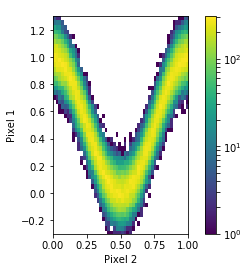

In [5]:
from matplotlib.colors import LogNorm
x2 = np.random.uniform(size=100000)
eps = np.random.normal(scale=0.1, size=100000)
hist2d = plt.hist2d(x2,x1(x2)+eps, bins=50, norm=LogNorm())
plt.xlim(0.0,1.0); plt.ylim(-0.3,1.3); plt.axes().set_aspect('equal')
plt.xlabel('Pixel 2'); plt.ylabel('Pixel 1')
plt.colorbar();
plt.savefig('histogram_of_structured_images.pdf')

As our intuition might have suggested, the data
generating distribution looks very similar to 
the structure suggested by the two dimensional
images plotted above. There is high probability
very near the actual curve 
$x_1 = \frac{1}{2} \cos(2\pi x_2)+\frac{1}{2}$ 
and low probability as we move away. We imposed
the uncertainty via the Gaussian noise term 
$\epsilon$. However, in real data the 
uncertainty can be due to the myriad sources
outlined above. In these cases a complex 
probability distribution isn't an arbitrary 
choice for representing the data, it becomes 
necessary. 

Hopefully we're now beginning to understand how
to interpret $p_{test}(x_1, x_2)$. One might say
$p_{test}$ measures how likely a certain 
configuration of $x_1$ and $x_2$ is to have 
arisen from the data generating process $f(t)$.
Therefore if one can learn the data generating
distribution, then they have a descriptive
measure of the true underlying data generating
process. This intuition extends to the 
$p_{data}(x)$ for faces that was presented 
above. A sample from the LFW dataset is shown in 
Figure \ref{fig:Agnelo_Queiroz_0001} on page
\pageref{fig:Agnelo_Queiroz_0001}. 

